# The Characteristics of a Tennis Match Winner

### Group 38 Project Proposal

#### Introduction
Likelihood of winning a game of tennis can be divided into four categories: strategy, technique, physical conditions, and mental game. While all components contribute to a win, we aim to test the importance of physical conditions by predicting the rank of a tennis player based on attributes such as height, age, and hand-dominance. To answer this question we will use data from the dataset “player_stats.csv”, which describes the player statistics for the top 500 tennis players worldwide.

#### Preliminary exploratory data analysis

##### Methods
The columns we will be using for this project are “Height”, “Plays” (hand-dominance), and “Age” to predict "Current Rank". We chose to use "Current Rank" rather than "Best Rank" because it is reflective of their current physical conditions and skill level as well as to avoid duplicate rankings in the dataset. We will be using a scatter plot to visualise the results by plotting players’ heights, hand-dominance, and age (on the x-axis) with their rankings (on the y-axis). There will be 3 separate scatter plots, one for each respective variable. We will be combining the results from the graphs into a linear regression model to answer our predictive question. The predictive question we aim to answer through this project is: Can we predict the current rank of an elite tennis player based on the simple atrributes of height, age and hand dominance?

##### Expected outcomes and significance:

- What do you expect to find?
- What impact could such findings have?
- What future questions could this lead to?

#### Preliminary exploratory data analysis:

In [1]:
# Setup
set.seed(3)

library(tidyverse)
library(tidymodels)
library(repr)
library(cowplot)
library(GGally)
library(ISLR)
#library(themis)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

#### First, we will tidy up our data:

In [2]:
# Load the data from the web
url <- "https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS"
tennis <- read_csv(url) 

# Fix column names
colnames(tennis) <- make.names(colnames(tennis))

# Select only relevant columns to our study.

tennis <- select(tennis, c(Age, Plays, Current.Rank, Height))

print("Table 1: Tennis lm Data")
head(tennis)

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 1: Tennis lm Data"


Age,Plays,Current.Rank,Height
<chr>,<chr>,<chr>,<chr>
26 (25-04-1993),Right-handed,378 (97),NA
18 (22-12-2001),Left-handed,326 (119),NA
32 (03-11-1987),Right-handed,178 (280),185 cm
21 (29-05-1998),Right-handed,236 (199),NA
27 (21-10-1992),Right-handed,183 (273),193 cm
22 (11-02-1997),Right-handed,31 (1398),NA


In [3]:
# Now we will tidy up our data further by getting rid of unnecessary information in certain columns (ex. dates, "cm", extra number next to rank)

# Separate unnecessary information from their original column into a new column
tennis <- separate(tennis, col = Age, into = c("Age", "x"), sep = " ", convert = TRUE) |> 
          separate(col = Current.Rank, into = c("Current.Rank", "y"), sep = " ", convert = TRUE) |>
          separate(col = Height, into = c("Height", "z"), sep = " ", convert = TRUE) 

# Delete unnecessary columns
tennis <- select(tennis, -c(x, y, z)) 

#Here we will mutate Plays to a factor so we can visulaize it easier 
tennis_lm_mutate <- tennis |>
mutate(Plays = as_factor(Plays))



print("Table 2: Tidy Tennis Data")
head(tennis_lm_mutate)

[1] "Table 2: Tidy Tennis Data"


Age,Plays,Current.Rank,Height
<int>,<fct>,<int>,<int>
26,Right-handed,378,NA
18,Left-handed,326,NA
32,Right-handed,178,185
21,Right-handed,236,NA
27,Right-handed,183,193
22,Right-handed,31,NA


#### Summary of Training Data
Now, we will summarize our training data to report the mean of our numeric predictors (Age and Height), as well as the number of missing observations and total observations. We also chose to remove the Height predictor in this section due to too many missing observations. 

In [4]:
# Split our data into training and testing
set.seed(1234) #DO NOT REMOVE
tennis_lm_split <- initial_split(tennis_lm_mutate %>% select(-Height), prop = 0.7, strata = Current.Rank) 
tennis_lm_train <- training(tennis_lm_split) 
tennis_lm_test <- testing(tennis_lm_split)

missing_obs <- sum(apply(tennis_lm_train, 1, function(x) any(is.na(x)))) # Used to find the number of missing observations  
                         
total_obs <- nrow(tennis_lm_train) # Used to find the total number of observations

mean_age <- mean(tennis_lm_train$Age, na.rm = TRUE) # Used to find the mean Age

          
tab <- matrix(c(mean_age, missing_obs, total_obs), ncol=3, byrow=TRUE) #used to create a table to express the answers.
colnames(tab) <- c('Mean Age','Missing Observations', 'Number of Rows')
rownames(tab) <- c('Value')
tab <- as.table(tab)
print("Table 3: Summary of Training Data")                        
tab





[1] "Table 3: Summary of Training Data"


       Mean Age Missing Observations Number of Rows
Value  25.93678             33.00000      349.00000

#### Distribution of Predictors
To better visualize our predictors, we seperate our training data into 4 different quartiles by their current rank, Lowest_quartile (lowest rank), Medium_low, Medium_high, Top_quartile (highest rank). We will then plot the quartiles against each of predictor variables to visualize their relationship with the different groups of rankings. 

In [5]:
ranks_list <- tennis_lm_train$Current.Rank

tennis_bins <- tennis_lm_train %>%
mutate(binned_cr = case_when(`Current.Rank` >= quantile(ranks_list,0.75, na.rm = T) ~ "Lowest_quartile",
                             `Current.Rank` >= quantile(ranks_list,0.5, na.rm = T) ~ "Medium_low",
                             `Current.Rank` >= quantile(ranks_list,0.25, na.rm = T) ~ "Medium_high",
                             `Current.Rank` >= quantile(ranks_list,0, na.rm = T) ~ "Top_quartile",
                             TRUE ~ "Other"))

print("Table 4: Training Data Sorted into 4 Quartiles")  
tennis_bins

[1] "Table 4: Training Data Sorted into 4 Quartiles"


Age,Plays,Current.Rank,binned_cr
<int>,<fct>,<int>,<chr>
22,Right-handed,31,Top_quartile
20,Right-handed,104,Top_quartile
19,Right-handed,22,Top_quartile
⋮,⋮,⋮,⋮
23,Left-handed,429,Lowest_quartile
32,Right-handed,416,Lowest_quartile
24,NA,419,Lowest_quartile


`summarise()` has grouped output by 'binned_cr'. You can override using the
`.groups` argument.


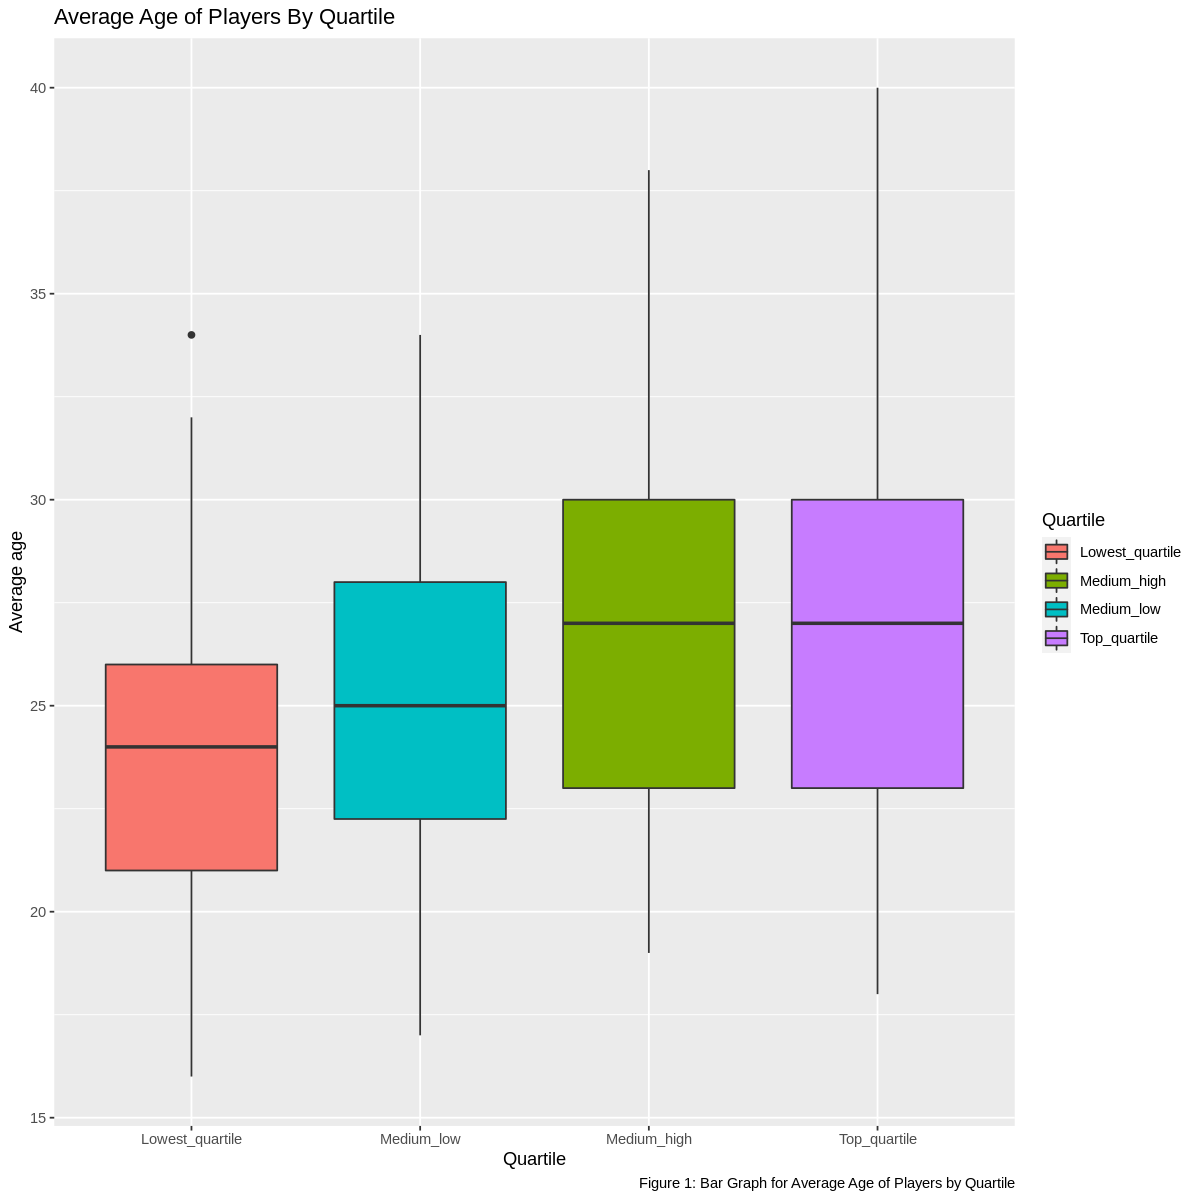

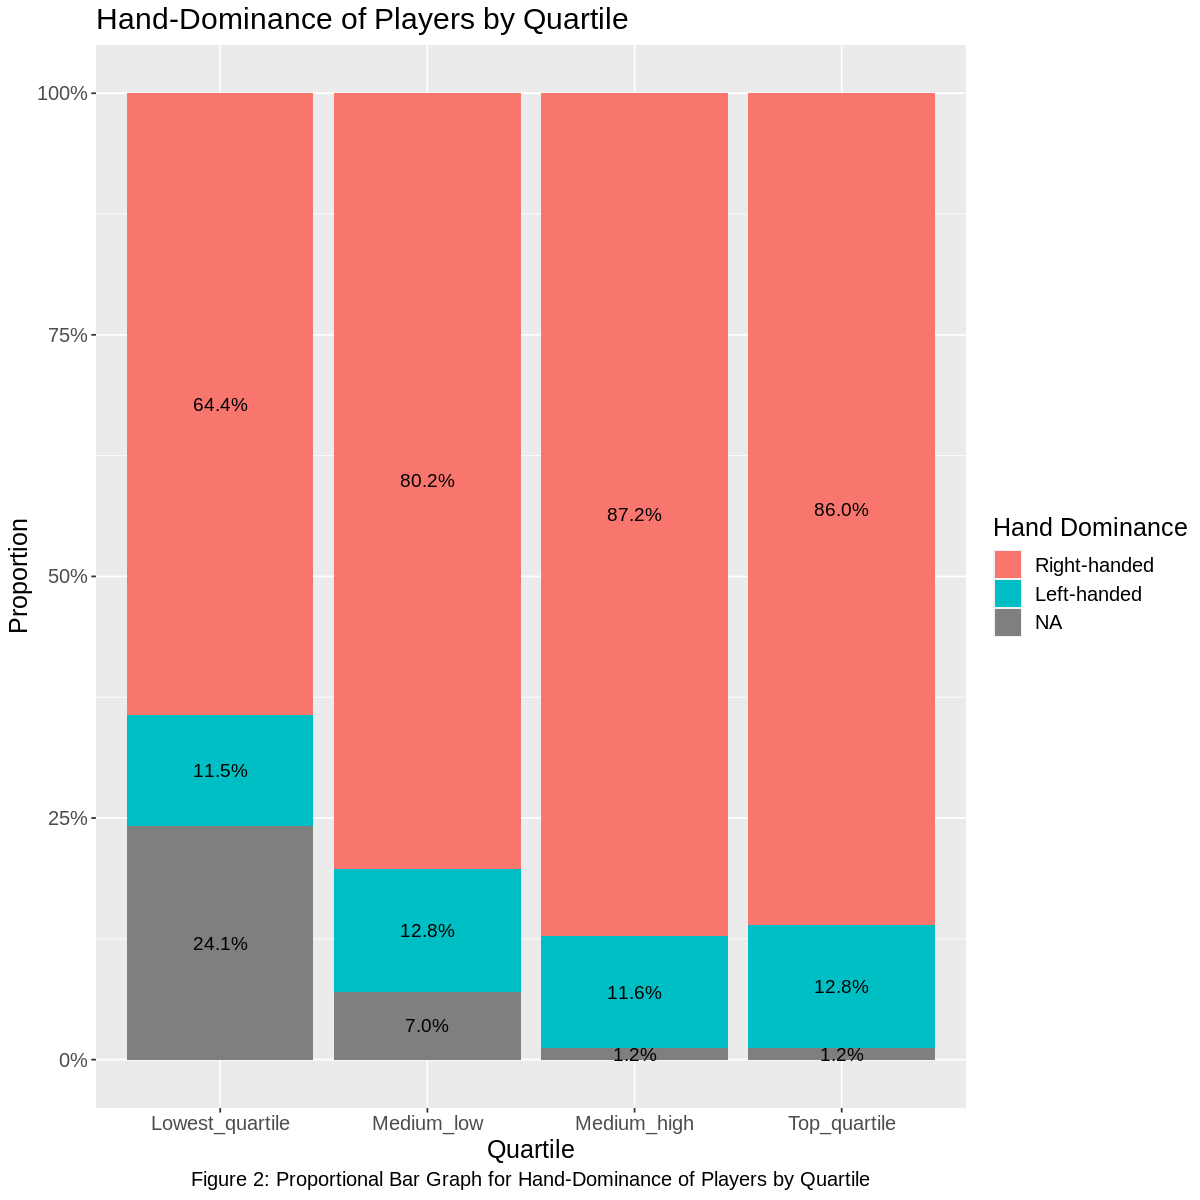

In [6]:
options(repr.plot.width = 10, repr.plot.height = 10)
# Create bar plots sorted by Quartile for each predictor variable 

# Calculate the average age for each Quartile
average_age <- tennis_bins |> filter(binned_cr != "Other") # |> group_by(binned_cr) |> summarise(mean = mean(Age))

# Create a bar plot showing the average age by Quartile
low_vs_age_plot <- ggplot(average_age, aes(x = factor(binned_cr, levels = c("Lowest_quartile", "Medium_low", "Medium_high", "Top_quartile")), y = Age, fill = binned_cr)) +
                    geom_boxplot() + ggtitle("Average Age of Players By Quartile") + labs(x = "Quartile", y = "Average age", fill = "Quartile", caption = "Figure 1: Bar Graph for Average Age of Players by Quartile") 
                    #scale_y_continuous(limits = c(0, ceiling(max(average_age$mean) / 2) * 2), breaks = seq(0, ceiling(max(average_age$mean) / 2) * 2, by = 2)) + theme(text = element_text(size = 15)) + theme(plot.caption = element_text(hjust = 0.5))

# Find the proportion of players who play left or right handed, or NA, seperated by Quartile
hand_prop <- tennis_bins |> filter(binned_cr != "Other") |> group_by(binned_cr, Plays) |> summarise(count = n()) |>
                            group_by(binned_cr) |> mutate(proportion = count / sum(count))

# Create a proportionality stacked bar plot of right vs left-handed Players by Quartile
plays_prop_plot <- ggplot(hand_prop, aes(x = factor(binned_cr, levels = c("Lowest_quartile", "Medium_low", "Medium_high", "Top_quartile")), y = proportion, fill = Plays)) +
  geom_bar(stat = "identity") +
  labs(x = "Quartile", y = "Proportion", fill = "Hand Dominance", title = "Hand-Dominance of Players by Quartile", caption = "Figure 2: Proportional Bar Graph for Hand-Dominance of Players by Quartile") +
  geom_text(aes(label = sprintf("%.1f%%", proportion*100)), 
            position = position_stack(vjust = 0.5), 
            size = 4) +
 scale_y_continuous(labels = percent_format()) + theme(plot.caption = element_text(hjust = 0.5)) + theme(text = element_text(size = 15))
 


low_vs_age_plot
plays_prop_plot

# Data Analysis
### Fitting a linear regression model
Using our training data, we fit a linear regression model and come up with an equation to predict the current rank. After finding our equation, we calculate the RMSE and RMSPE to try and understand how well our model fits the data.

In [7]:
lm_spec <- linear_reg() |> 
set_engine("lm") |>
set_mode("regression")

tennis_recipe <- recipe(Current.Rank ~., data = tennis_lm_train)

tennis_fit <- workflow() |>
add_model(lm_spec) |>
add_recipe(tennis_recipe) |>
fit(data = tennis_lm_train)

tennis_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
     (Intercept)               Age  PlaysLeft-handed  
         422.839            -7.111            -5.190  


### Equation of our model's line

$Current Rank = 422.839 -7.111 Age -5.190 (Plays(Left-handed))$

Note that in this equation the variable Plays, which has values Right-handed and Left-handed, is shown as $Plays(Left-handed)$. This is because we mutated it as a factor in the tidying porcess of our analysis. As such, Left-handed and Right-handed both correspond to 1 and 0 respectively. Since Right-handed is 0, it effectively disappears from our equation.

#### Calculating an RMSE

In [8]:
tennis_rmse <- tennis_fit |>
predict(tennis_lm_train) |>
bind_cols(tennis_lm_train) |>
metrics(truth = Current.Rank, estimate = .pred) |>
filter(.metric == "rmse") |>
pull()

print("RMSE for Current Rank")
print(tennis_rmse)

[1] "RMSE for Current Rank"
[1] 138.137


$$RMSE = 138.137$$

#### Calculating RMSPE

In [9]:
tennis_test_results <- tennis_fit |>
predict(tennis_lm_test) |>
bind_cols(tennis_lm_test) 

tennis_rmspe <- tennis_test_results |>
metrics(truth = Current.Rank, estimate = .pred) |>
filter(.metric == "rmse") |>
pull()

print("RMSPE for Current Rank")
print(tennis_rmspe)

[1] "RMSPE for Current Rank"
[1] 135.5216


$$RMSPE = 135.52156$$

Unfortunately, our value for RMSPE is very high indication a poor fit for the data. An error of 135 is very high when considering we are only predicting within the top 500 ranks. The reasons why our model is not a good fit will be discussed more throughly in the discussion section.

## Visualizing our data
Here, we will create a residuals plot of our data.

Warning message:
“Removed 15 rows containing missing values (geom_point).”


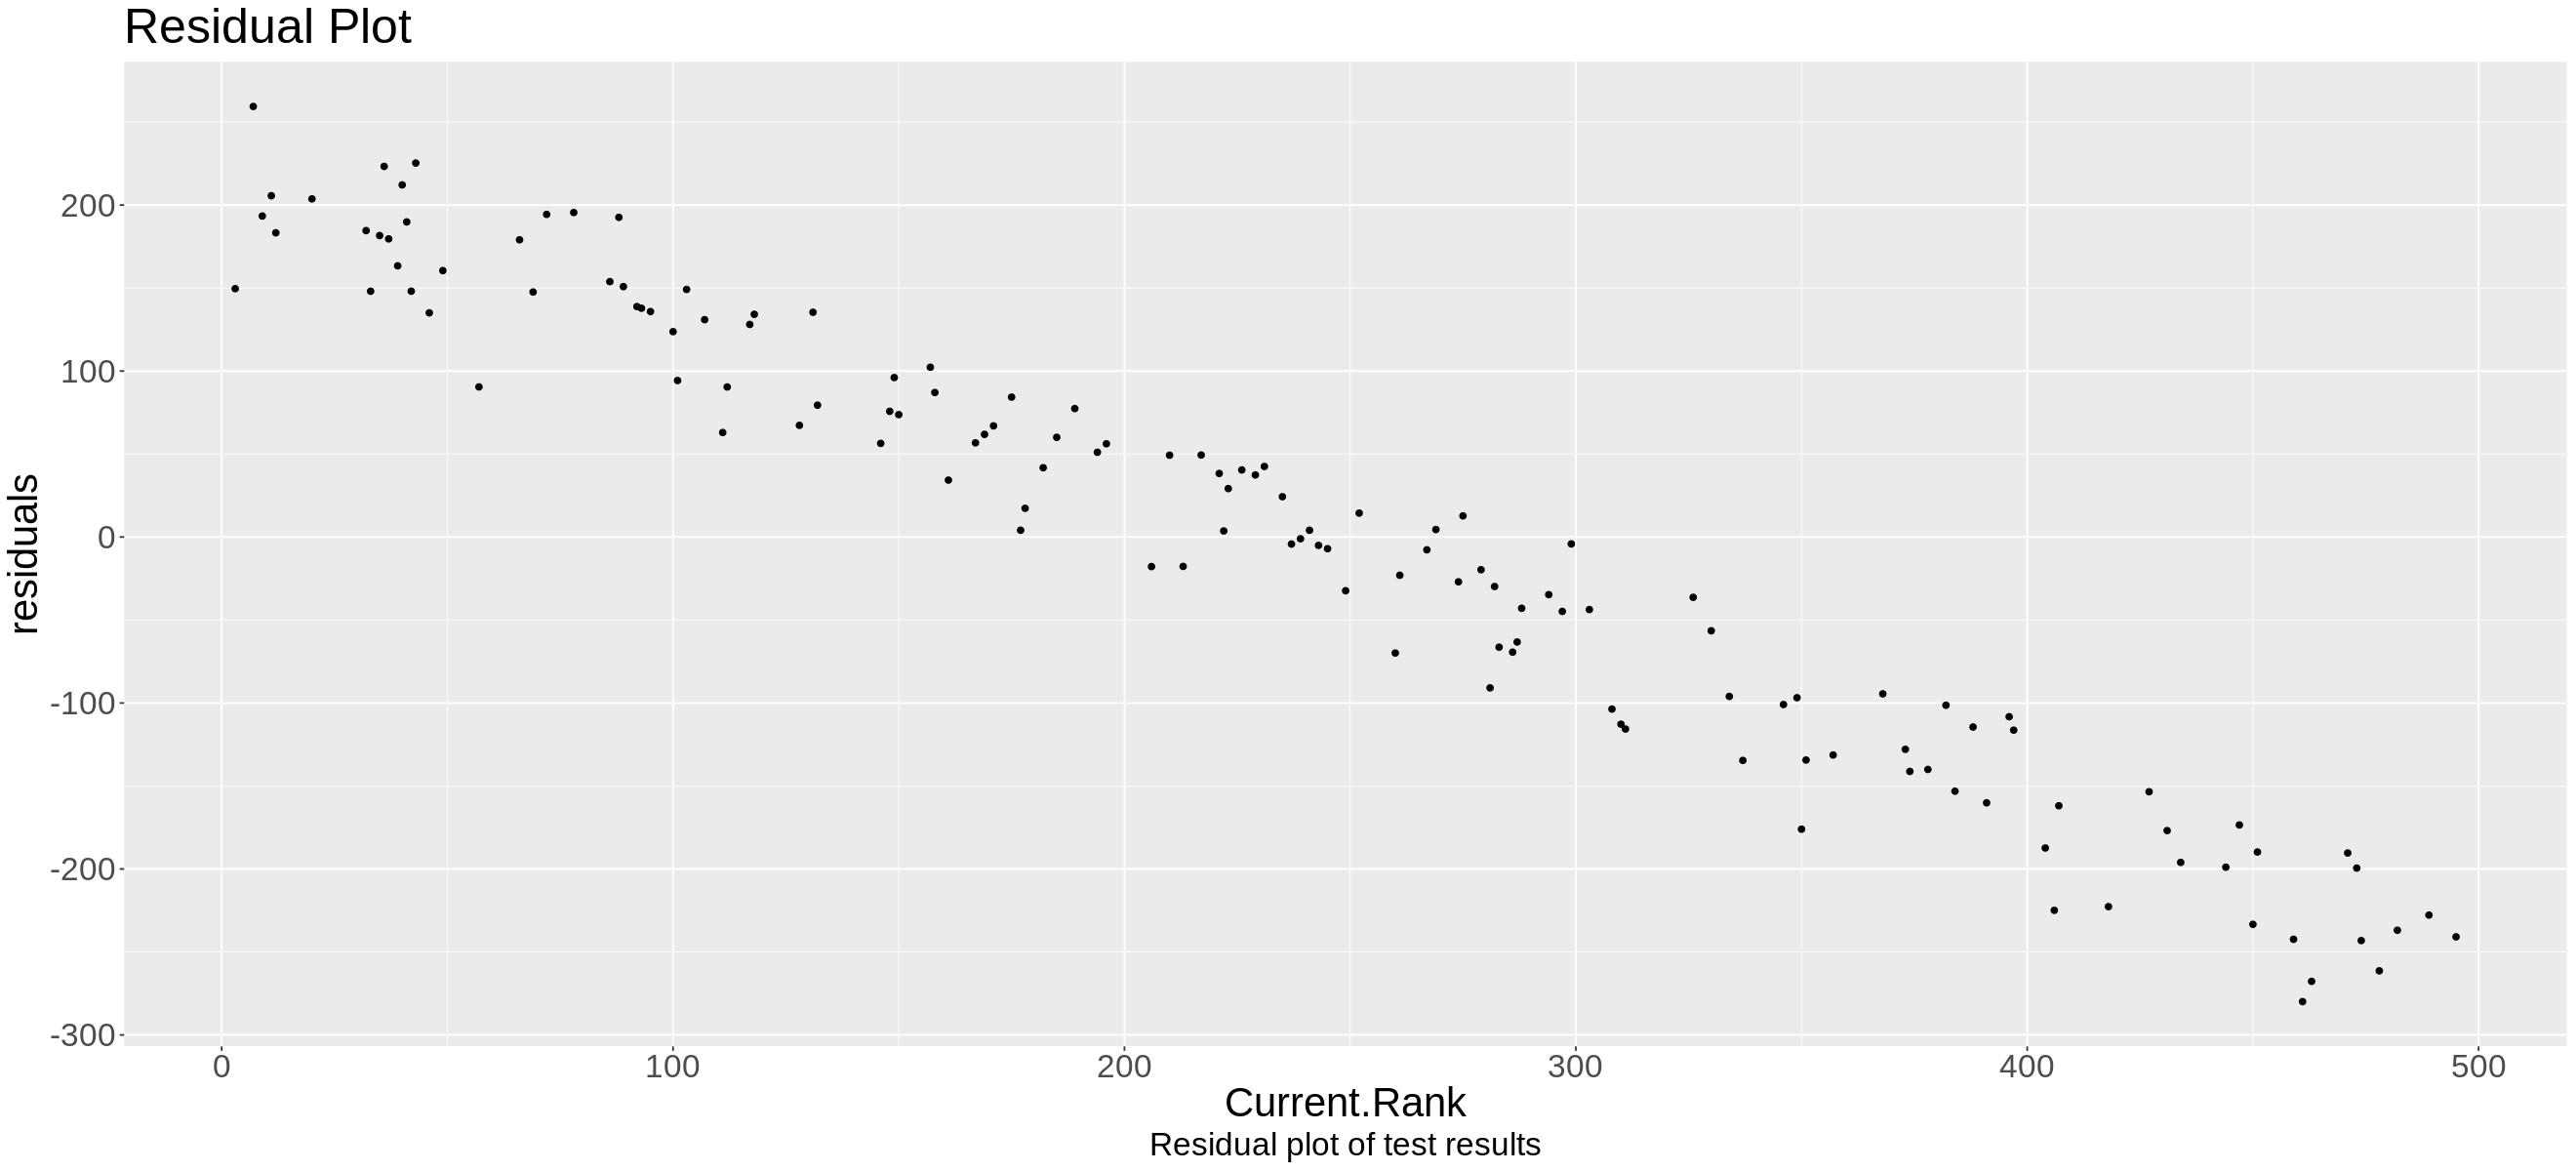

In [10]:
options(repr.plot.width = 22, repr.plot.height = 10)

residuals_plot <- tennis_test_results %>%
mutate(residuals = `.pred` - `Current.Rank`) %>%
ggplot()+
geom_point(aes(x = `Current.Rank`, y = residuals)) + labs(caption = "Residual plot of test results") + 
ggtitle("Residual Plot") +
theme(text = element_text(size = 25)) + theme(plot.caption = element_text(hjust = 0.5))

residuals_plot

As we can see in the above residuals plot, our model predicts best right around the middle of the ranks, approximately 250. When we reach the extremes, either 500 or 1, our model begins to fail quite seriously. Possible reasons for this will be examined in the discussion section below.

## Knn Regression

In this section, we will do another analysis, this time using knn regrression to determine if linear or knn regression better fits this model.

#### Tidying Adjustments

In [11]:
tennis_selected <- tennis |> #here we deselect hieght as we already know its a poor predictor
select(-Height)

tennis_knn_mutate <- tennis_selected |> #here we mutate Plays to a numerical column
mutate(Plays = case_when(Plays == "Right-handed" ~ 1,
                 Plays == "Left-handed" ~ 0,
                        ))

print("Table 5: Tennis knn Data")
head(tennis_knn_mutate)

[1] "Table 5: Tennis knn Data"


Age,Plays,Current.Rank
<int>,<dbl>,<int>
26,1,378
18,0,326
32,1,178
21,1,236
27,1,183
22,1,31


#### Splitting our data

In [12]:
tennis_knn_split <- initial_split(tennis_knn_mutate, prop = 0.7, strata = Current.Rank)
tennis_knn_train <- training(tennis_knn_split)
tennis_knn_test <- testing(tennis_knn_split)
tennis_knn_train

Age,Plays,Current.Rank
<int>,<dbl>,<int>
20,1,104
19,1,22
23,1,4
⋮,⋮,⋮
25,1,486
32,1,416
23,0,495


#### Finding the best k value for our model

In [25]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> #here we create a model for the knn regression
set_engine("kknn") |>
set_mode("regression")

knn_recipe <- recipe(Current.Rank ~ Age + Plays, data = tennis_knn_train) |>  #We create a recipe and scale using our training data
step_scale(all_predictors()) |>
step_center(all_predictors())

knn_vfold <- vfold_cv(tennis_knn_train, vfold = 7, strata = Current.Rank) #We use seven folds here to get roughly 50 rows per fold.

knn_workflow <- workflow() |>
add_recipe(knn_recipe) |>
add_model(knn_spec)

gridvals <- tibble(neighbors = seq(1, 10, 1))

knn_results <- knn_workflow |>
tune_grid(resamples = knn_vfold, grid = gridvals) 
#collect_metrics()

#k_best <- knn_results |>
#filter(.metric == "rmse") |>
#arrange(mean) |>
#head(1)

x Fold01: preprocessor 1/1, model 1/1 (predictions):
  Error in `mutate()`:
  ! Problem while computing `.row = orig_rows`.
  ✖ `.row` must be size 31 or 1, not 36.

x Fold02: preprocessor 1/1, model 1/1 (predictions):
  Error in `mutate()`:
  ! Problem while computing `.row = orig_rows`.
  ✖ `.row` must be size 34 or 1, not 36.

x Fold03: preprocessor 1/1, model 1/1 (predictions):
  Error in `mutate()`:
  ! Problem while computing `.row = orig_rows`.
  ✖ `.row` must be size 33 or 1, not 36.

x Fold04: preprocessor 1/1, model 1/1 (predictions):
  Error in `mutate()`:
  ! Problem while computing `.row = orig_rows`.
  ✖ `.row` must be size 34 or 1, not 36.

x Fold05: preprocessor 1/1, model 1/1 (predictions):
  Error in `mutate()`:
  ! Problem while computing `.row = orig_rows`.
  ✖ `.row` must be size 30 or 1, not 36.

x Fold06: preprocessor 1/1, model 1/1 (predictions):
  Error in `mutate()`:
  ! Problem while computing `.row = orig_rows`.
  ✖ `.row` must be size 31 or 1, not 36.

x Fo

## Discussion